# Amazon sentiment analysis: Spectral Feature Alignment Simplified

Data downloaded from: processed_acl.tar.gz, processed for John Blitzer, Mark Dredze, Fernando Pereira. Biographies, Bollywood, Boom-boxes and Blenders: Domain Adaptation for Sentiment Classification. Association of Computational Linguistics (ACL), 2007

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from read_funcs import organise_data, vectorise_data, select_high_freq_data
%matplotlib inline

In [2]:
src = 'dvd'
tgt = 'kitchen'
XB, Y_src, XD, Y_tgt = organise_data(src, tgt)

dvd 1000 -1000
kitchen 1000 -1000


In [28]:
# Vectorise the raw data
X_src, X_tgt, features = vectorise_data(XB, XD)
# Reduce the no. of features
N = 10000
X_src, X_tgt, features = select_high_freq_data(X_src, X_tgt, features, N)

In [4]:
# Base case examined in Sent_InstanceWeighting

## SFA find domain independent features using mutual information

In [5]:
def compute_mutual_info(X, Y):
    N = X.shape[1]
    mutual_info = []
    for i in range(N):
        mutual_info.append(mutual_info_score(X[:,i], Y))
    return mutual_info

In [25]:
X = np.r_[X_src, X_tgt]
Y = np.r_[np.ones(X_src.shape[0]), np.zeros(X_tgt.shape[0])]
print(X.shape, Y.shape)

(4000, 10000) (4000,)


In [26]:
# Features descriminant for which domain it comes from.
mutual_info_src_tgt = compute_mutual_info(X, Y)

In [29]:
# Features descriminant for the source domain label
mutual_info_src = compute_mutual_info(X_src, Y_src)

To select features that are non-descriminant for which domain and are descriminant for the source domain. We subtract the two mutual information socre.

In [30]:
mutual_info_src_tgt = [mutual_info_src_tgt[i] - mutual_info_src[i] \
                       for i in range(len(mutual_info_src))]
features = np.asarray(features)
sort_idx = np.argsort(mutual_info_src_tgt)
print(features[sort_idx[:20]])

['waste' 'great' 'worst' 'the_worst' 'bad' 'waste_of' 'not' 'excellent'
 'horrible' 'best' 'awful' 'love' 'a_great' 'the_best' 'well' 'your_money'
 'wonderful' 'no' 'not_worth' 'terrible']


In [62]:
src_waste_idx = (X_src[:, sort_idx[0]] > 0)*(X_src[:, sort_idx[1]] == 0)
X_src_waste = X_src[src_waste_idx, :]
Y_src_waste = Y_src[src_waste_idx]
tgt_waste_idx = (X_tgt[:, sort_idx[0]] > 0)*(X_tgt[:, sort_idx[1]] == 0)
X_tgt_waste = X_tgt[tgt_waste_idx, :]
Y_tgt_waste = Y_tgt[tgt_waste_idx]
src_great_idx = (X_src[:, sort_idx[1]] > 0)*(X_src[:, sort_idx[0]] == 0)
X_src_great = X_src[src_great_idx, :]
Y_src_great = Y_src[src_great_idx]
tgt_great_idx = (X_tgt[:, sort_idx[1]] > 0)*(X_tgt[:, sort_idx[0]] == 0)
X_tgt_great = X_tgt[tgt_great_idx, :]
Y_tgt_great = Y_tgt[tgt_great_idx]

In [38]:
Y_src = np.asarray(Y_src)
Y_src_sub = Y_src[X_src[:, sort_idx[0]] > 0]
Y_src_sub = np.r_[Y_src_sub,Y_src[(X_src[:, sort_idx[1]] > 0)*(X_src[:, sort_idx[0]] == 0)]]
Y_tgt = np.asarray(Y_tgt)
Y_tgt_sub = Y_tgt[X_tgt[:, sort_idx[0]] > 0]
Y_tgt_sub = np.r_[Y_tgt_sub,Y_tgt[(X_tgt[:, sort_idx[1]] > 0)*(X_tgt[:, sort_idx[0]] == 0)]]

In [39]:
X = np.r_[X_src_waste, X_tgt_waste, X_src_great, X_tgt_great]
X = X[:, sort_idx]
features = features[sort_idx]

IndexError: index 9682 is out of bounds for axis 1 with size 100

In [40]:
l = 2
m = 100
X = X[:,:m]
features = features[:m]
Phi_DI = X[:, :l]
Phi_DS = X[:, l:]
print(Phi_DI.shape, Phi_DS.shape)

(1206, 2) (1206, 98)


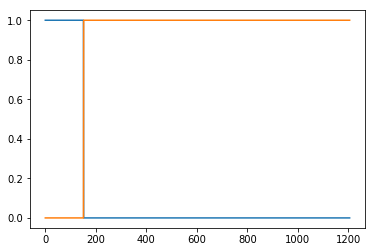

In [41]:
# Binarise the data
binarizer = Binarizer().fit(Phi_DI)
Phi_DI = binarizer.transform(Phi_DI)
Phi_DS = binarizer.transform(Phi_DS)
plt.plot(Phi_DI[:,0])
plt.plot(Phi_DI[:,1])

In [43]:
print(X_src_waste.shape[0],X_tgt_waste.shape[0],X_src_great.shape[0],X_tgt_great.shape[0])

80 72 513 541


In [44]:
M = np.dot(Phi_DS.T, Phi_DI)
non_zero_entries = np.sum(M, axis = 1) > 0
print('nonzero entries', np.sum(np.sum(M, axis = 1) == 0))
Phi_DS = Phi_DS[:,non_zero_entries]
X = X[:, np.r_[np.array([True, True]), non_zero_entries]]
features = features[np.r_[np.array([True, True]), non_zero_entries]]

nonzero entries 0


## SFA: find low-dimensional mapping

In [46]:
M = np.dot(Phi_DS.T, Phi_DI)
m = X.shape[1]
A = np.c_[np.zeros((m-l, m-l)), M]
A = np.r_[A, np.c_[M.T, np.zeros((l,l))]]
print(M.shape, A.shape)

(98, 2) (100, 100)


In [48]:
# Build Diagonal matrix D
sum_col = np.sum(A, axis = 1)
D_inv_sqrt = np.diag(1/np.sqrt(sum_col))

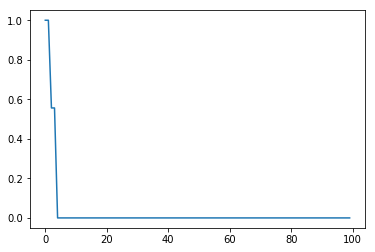

In [49]:
k = 100 # clusters
L = np.dot(D_inv_sqrt,A).dot(D_inv_sqrt)
W, V = np.linalg.eig(L) # really slow
idx = abs(W).argsort()[::-1]
W = W[idx]
V = V[:, idx]
plt.plot(abs(W))

In [50]:
U = V[:m-l, :k]
U = np.real(U)
U.shape

(98, 100)

In [53]:
u1 = U[:,2]
u1_sorted = sorted(range(len(u1)), key=lambda i: np.abs(u1[i]))
u1_pos_subspace = [features[i+2] for i in u1_sorted[-1:-21:-1]]
u1_neg_subspace = [features[i+2] for i in u1_sorted[:20]]
print(np.asarray(u1_pos_subspace))
print(np.asarray(u1_neg_subspace))

['waste_of' 'waste_your' "don't_waste" 'money' 'a_waste' 'your_money'
 'your_time' 'a_great' 'money_on' 'best' 'dumb' 'my_money' 'well'
 'the_best' 'horrible' 'love' 'perfect' "don't" 'also' 'i']
['paid' 'not_recommend' 'disappointment' 'disappointing' 'i_was'
 'looks_like' 'actual' 'lame' 'poorly' 'worse' 'ridiculous' 'poor' 'crap'
 'worst_movies' 'let_me' 'fails' 'at_all' 'atrocious' 'not_funny' 'ruined']


In [63]:
k = 4
U = V[:m-l, :k]

In [64]:
gamma = 0.6
X_src_sub = np.r_[X_src_waste[:, sort_idx[:m]], X_src_great[:, sort_idx[:m]]]
X_tgt_sub = np.r_[X_tgt_waste[:, sort_idx[:m]], X_tgt_great[:, sort_idx[:m]]]
Y_src_sub = np.r_[Y_src_waste, Y_src_great]
Y_tgt_sub = np.r_[Y_tgt_waste, Y_tgt_great]
X_src_aug = np.c_[X_src_sub, gamma*np.dot(X_src_sub[:,l:], U)]
X_tgt_aug = np.c_[X_tgt_sub, gamma*np.dot(X_tgt_sub[:,l:], U)]

In [65]:
X_src_aug.shape

(593, 104)

In [66]:
def tune_reg_param_unsupervised(C_test, X_src_SCL, Y_src, X_tgt, Y_tgt, dev_size):
    X_train, X_dev, Y_train, Y_dev = train_test_split(X_src_SCL, Y_src, test_size = dev_size, random_state = 3)
    acc_train = []
    acc_dev = []
    for C in C_test:
        model_SCL = LogisticRegression(C = C) 
        model_SCL.fit(X_train, Y_train)
        acc_train.append(model_SCL.score(X_train, Y_train))
        acc_dev.append(model_SCL.score(X_dev, Y_dev))
    C_opt = C_test[np.argmax(acc_dev)]
    model_SCL = LogisticRegression(C = C_opt) 
    model_SCL.fit(X_train, Y_train)
    print('optimal alpha', C_opt, 'max acc', max(acc_dev),'test acc', model_SCL.score(X_tgt, Y_tgt))
    plt.plot(C_test, acc_train)
    plt.plot(C_test, acc_dev)

optimal alpha 0.270526315789 max acc 0.806722689076 test acc 0.814029363785


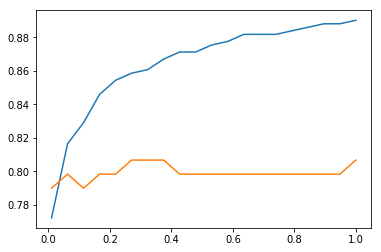

In [71]:
C_test = np.linspace(0.01,1,20)
tune_reg_param_unsupervised(C_test, X_src_sub, Y_src_sub, X_tgt_sub, Y_tgt_sub, 0.2)

optimal alpha 0.270526315789 max acc 0.806722689076 test acc 0.815660685155


/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


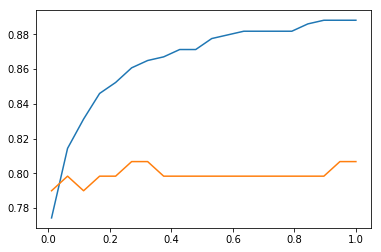

In [72]:
tune_reg_param_unsupervised(C_test, X_src_aug, Y_src_sub, X_tgt_aug, Y_tgt_sub, 0.2)

In [76]:
model = LogisticRegression(C = 0.3) 
model.fit(X_src_sub, Y_src_sub)
print('gamma: {}, train {:s} acc: {:.3f}, test {:s} acc: {:.3f}'\
      .format(gamma, src, model.score(X_src_sub, Y_src_sub), \
              tgt, model.score(X_tgt_sub, Y_tgt_sub)))

gamma: 100.0, train dvd acc: 0.855, test kitchen acc: 0.824


In [77]:
gamma_list = np.logspace(-1,4,6)
for gamma in gamma_list:
    X_src_aug = np.c_[X_src_sub, gamma*np.dot(X_src_sub[:,l:], U)]
    X_tgt_aug = np.c_[X_tgt_sub, gamma*np.dot(X_tgt_sub[:,l:], U)]
    model = LogisticRegression(C = 0.3) 
    model.fit(X_src_aug, Y_src_sub)
    print('gamma: {}, train {:s} acc: {:.3f}, test {:s} acc: {:.3f}'\
          .format(gamma, src, model.score(X_src_aug, Y_src_sub), \
                  tgt, model.score(X_tgt_aug, Y_tgt_sub)))

gamma: 0.1, train dvd acc: 0.853, test kitchen acc: 0.824
gamma: 1.0, train dvd acc: 0.853, test kitchen acc: 0.829
gamma: 10.0, train dvd acc: 0.857, test kitchen acc: 0.832
gamma: 100.0, train dvd acc: 0.858, test kitchen acc: 0.834
gamma: 1000.0, train dvd acc: 0.858, test kitchen acc: 0.830
gamma: 10000.0, train dvd acc: 0.804, test kitchen acc: 0.809


/Users/meichenlu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
